In [1]:
from pepnets.PeptideNetwork import PeptideNetwork
import random
import pandas as pd
import numpy as np

random.seed(42)
np.random.seed(42)

sus_scrofa = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
sus_scrofa["Entry Name"] = sus_scrofa["Entry Name"].apply(lambda x: x.split("_")[0])
datamatrix = pd.read_csv("../data/data.csv")
is_multi = datamatrix["Protein"].value_counts() > 3
filtered = datamatrix[datamatrix["Protein"].isin(is_multi[is_multi].index)]

pnet = PeptideNetwork(
    datamatrix=filtered,
    protein_database=sus_scrofa,
)
_ = pnet.create_network(distance_cutoff=4)

Reading peptides...


<Figure size 640x480 with 0 Axes>

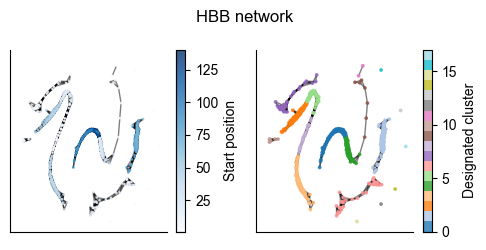

In [2]:
clusters = pnet.get_clusters(resolution=0.8, random_seed=42)
pnet.plot_protein("HBB", save_str=None, figsize=(5, 2.5))

In [3]:
clusters.merge_nearby_clusters(wiggle_room=2)
clusters.remove_small_clusters(threshold=3)
clusters.reindex()

Merged 39 clusters

Removed 0 clusters
Removed 848 clusters
Removed 279 clusters


In [4]:
design = pd.read_csv("../data/design.csv")
topn = pd.read_csv("../data/topn.csv")
clusters_df = pd.read_csv("../data/allClusters.tsv", sep="\t")

/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


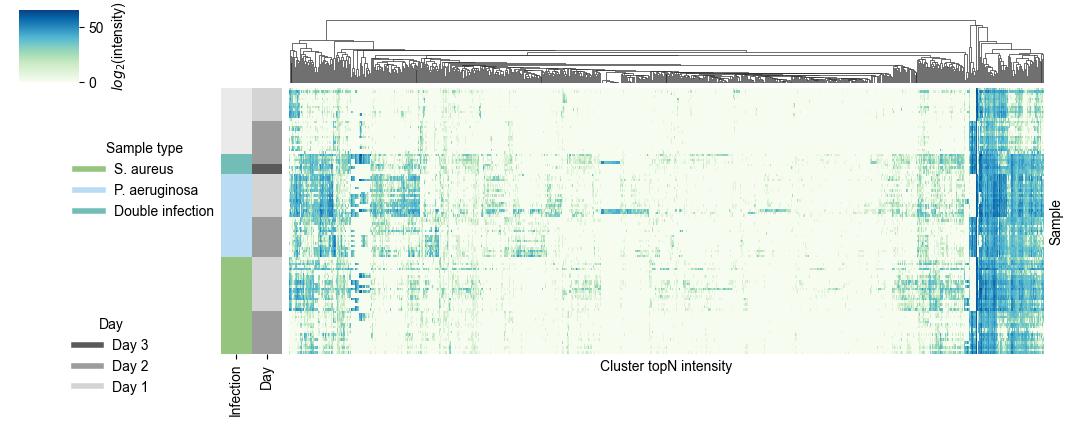

In [5]:
import seaborn as sns

from matplotlib.lines import Line2D

from palette import group_palette, day_palette

topn = pd.read_csv("../data/topn.csv")
design = design.sort_values(["group", "day"])
design = design[design["group"] != "Accidental double infection"]
samples = design["sample"]
topn = topn.reindex(samples, axis=1)

group = pd.Series(design["group"])
day = pd.Series(design["day"])
group_colors = group.map(group_palette)
day_colors = day.map(day_palette)
group_palette.pop("Accidental double infection")


g = sns.clustermap(
    topn.T,
    row_cluster=False,
    row_colors=[group_colors.values, day_colors.values],
    cmap="GnBu",
    figsize=(12, 4),
    cbar_kws={"label": r"$log_2$(intensity)"},
)
g.ax_heatmap.tick_params(left=False, bottom=False, right=False)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel("Cluster topN intensity")
g.ax_heatmap.set_ylabel("Sample")
g.ax_row_colors.set_xticks([0.5, 1.5], ["Infection", "Day"], rotation=90)


legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l)
    for l, c in zip(group_palette.keys(), group_palette.values())
]
days_elements = [
    Line2D([0], [0], color=c, lw=4, label=l)
    for l, c in zip(day_palette.keys(), day_palette.values())
]

legend_elements = legend_elements[:-1]

# Create the figure

g.ax_col_dendrogram.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, -0.7),
    title="Sample type",
)
g.ax_row_dendrogram.legend(
    frameon=False,
    handles=days_elements,
    loc="lower left",
    bbox_to_anchor=(0.25, -0.2),
    title="Day",
)

{'S10AC_4', 'FA5_3', 'COF1_3', 'CLUS_12', 'F1RX36_38', 'TPM3_1', 'ALBU_16', 'APOA4_1', 'LOX15_1', 'ACTB_14', 'CO3_20', 'LOX15_2', 'APOE_8', 'TYB10_1', 'ACTS_21', 'THRB_12', 'CO3_22', 'TBB_0', 'PPIA_7', 'CAZA1_1', 'ANXA1_7', 'APOE_10', 'SAA4_0', 'CO3_17', 'PMP23_7', 'LOX15_0', 'ACTS_22', 'B2MG_4', 'FETUA_0', 'THRB_10', 'TRFL_6', 'RS21_0', 'ACTB_23', 'ACTB_24', 'LOX15_3', 'ACTS_6', 'OSTF1_2', 'VTNC_5', 'ACTS_16', 'ANXA1_10'}
{'TRFE_14', 'PGK1_3', 'PG5_0', 'TRFL_3', 'PG5_1', 'ITIH2_16', 'CBG_1', 'ITIH2_21', 'PG5_3', 'HMGB2_4', 'HBE_1', 'PG3_2', 'PG2_2', 'PTBP1_4', 'LAC_0', 'ITIH2_5', 'APOA4_4', 'GELS_5', 'H33_1', 'PG4_4', 'HPT_4', 'GELS_6', 'CLUS_8', 'HMGB2_5', 'PGK1_0', 'OLR1_2', 'ITIH2_8', 'S10AC_2', 'HBA_4', 'ITIH2_0', 'G3P_22', 'GELS_8', 'PG4_0', 'ITIH1_4', 'PG2_4', 'CLUS_3', 'PGK1_1', 'ENOB_0', 'ILEU_1', 'PG4_1', 'TRFE_1', 'GELS_1', 'COF1_9', 'ITIH1_0', 'CO3_7', 'HMGB2_11', 'ACTS_4', 'PG1_1', 'ITIH1_2', 'GLRX1_2', 'PG5_2', 'ITIH2_13', 'ANXA1_2', 'PG1_5', 'PG4_5', 'A1AT_2', 'HMGB2_10'

Text(0, 0.5, 'P. aeruginosa')

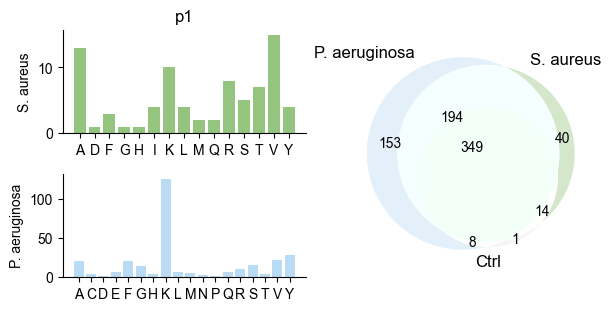

In [6]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

topn = pd.read_csv("../data/topn.csv").set_index("Cluster")
days = ["Day 1", "Day 2"]

groups = ["P. aeruginosa", "S. aureus", "Ctrl"]

design_day = design[design["day"].isin(days)]

venn_dict = {}


all_clusters = clusters_df

for group in groups:
    group_values = topn[design_day[design_day["group"] == group]["sample"]].T

    means = group_values.mean(axis=0)
    means = means[means > 0]
    venn_dict[group] = set(means.index.values.tolist())


fig, axs = plt.subplot_mosaic(
    [
        [
            "upper left",
            "right",
        ],
        [
            "lower left",
            "right",
        ],
    ],
    figsize=(6, 3),
    layout="constrained",
)

venn3(
    venn_dict.values(),
    venn_dict.keys(),
    set_colors=[group_palette[group] for group in groups],
    ax=axs["right"],
)


for ax, group in zip(
    [axs["upper left"], axs["lower left"]], ["S. aureus", "P. aeruginosa"]
):
    pa = venn_dict[group].copy()
    testing = groups.copy()
    testing.remove(group)
    for cluster in venn_dict[testing[0]].union(venn_dict[testing[1]]):
        if cluster in pa:
            pa.remove(cluster)
    print(pa)
    unique_clusters = all_clusters[all_clusters["ID"].isin(pa)].copy()
    unique_clusters["count"] = 1
    countN = unique_clusters.groupby("Np1").sum(numeric_only=True)["count"]
    countC = unique_clusters.groupby("Cp1").sum(numeric_only=True)["count"]
    count = pd.DataFrame({"C": countC, "N": countN}).fillna(0)
    count["tot"] = count["C"] + count["N"]
    ax.bar(x=count.index, height=count["tot"], color=group_palette[group])
    sns.despine(ax=ax)


axs["upper left"].set_title("p1")

axs["upper left"].set_ylabel("S. aureus")
axs["lower left"].set_ylabel("P. aeruginosa")

Text(0, 0.5, 'Day 3')

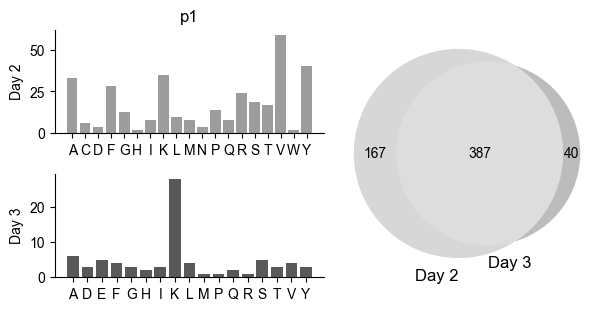

In [7]:
from matplotlib_venn import venn2

days = ["Day 2", "Day 3"]

groups = ["Double infection"]

design_group = design[design["group"].isin(groups)]

venn_dict = {}


for day in days:
    day_values = topn[design_group[design_group["day"] == day]["sample"]].T

    means = day_values.mean(axis=0)
    means = means[means > 0]
    venn_dict[day] = set(means.index.values.tolist())


fig, axs = plt.subplot_mosaic(
    [
        [
            "upper left",
            "right",
        ],
        [
            "lower left",
            "right",
        ],
    ],
    figsize=(6, 3),
    layout="constrained",
)

venn2(
    venn_dict.values(),
    venn_dict.keys(),
    set_colors=[day_palette[day] for day in days],
    ax=axs["right"],
)


for ax, day in zip([axs["upper left"], axs["lower left"]], ["Day 2", "Day 3"]):
    pa = venn_dict[day].copy()
    testing = days.copy()
    testing.remove(day)
    for cluster in venn_dict[testing[0]]:
        if cluster in pa:
            pa.remove(cluster)

    unique_clusters = all_clusters[all_clusters["ID"].isin(pa)].copy()

    unique_clusters["count"] = 1
    countN = unique_clusters.groupby("Np1").sum(numeric_only=True)["count"]
    countC = unique_clusters.groupby("Cp1").sum(numeric_only=True)["count"]
    count = pd.DataFrame({"C": countC, "N": countN}).fillna(0)
    count["tot"] = count["C"] + count["N"]
    ax.bar(x=count.index, height=count["tot"], color=day_palette[day])
    sns.despine(ax=ax)


axs["upper left"].set_title("p1")

axs["upper left"].set_ylabel("Day 2")
axs["lower left"].set_ylabel("Day 3")

/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/erikh

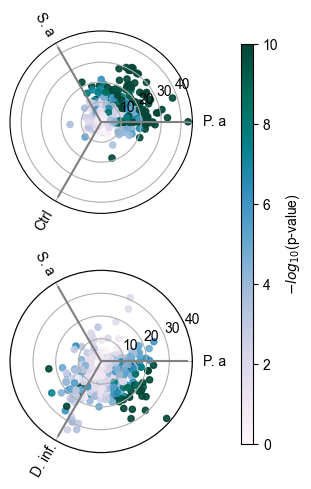

In [8]:
import numpy as np
from scipy.stats import f_oneway

topn = pd.read_csv("../data/topn.csv")


def create_de(topn, design, groups, days):
    de_dict = {}
    design_day = design[design["day"].isin(days)]

    for group in groups:
        group_values = topn[design_day[design_day["group"] == group]["sample"]].T
        means = group_values.mean(axis=0).replace(np.nan, 0.01)

        de_dict["cluster"] = topn.index
        de_dict[f"{group}"] = means

    anova = []

    for i, row in topn.iterrows():
        group_values = []
        for group in groups:
            row_values_for_group = row[
                design_day[design_day["group"] == group]["sample"]
            ].values.tolist()
            group_values.append(row_values_for_group)
        f, p = f_oneway(*group_values)
        anova.append(-np.log10(p))

    de_dict["anova"] = anova

    de = pd.DataFrame(de_dict).set_index("cluster")

    de.replace(np.inf, 10, inplace=True)
    de.replace(-np.inf, 10, inplace=True)

    de["sums"] = de.mean(axis=1)
    de.fillna(0, inplace=True)
    return de


groups = ["P. aeruginosa", "S. aureus", "Ctrl"]
days = ["Day 1", "Day 2"]

de = create_de(topn, design, groups, days)


def get_angle(a, b):
    if a <= 0:
        return np.pi + np.arctan(b / a)
    return np.arctan(b / a)


def get_complex(magnitude, angle):
    return magnitude * np.cos(angle) + magnitude * 1j * np.sin(angle)


def rotate_labels(y_offset):
    angles = np.linspace(0, 2 * np.pi, len(ax.get_xticklabels()) + 1)
    angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
    angles = np.rad2deg(angles)

    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x, y = label.get_position()
        lab = ax.text(
            x,
            y - y_offset,
            label.get_text(),
            transform=label.get_transform(),
            ha=label.get_ha(),
            va=label.get_va(),
        )
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])


def plot_polar(ax, de, groups, size=1, colors=None, cmap="coolwarm"):
    values = de[groups].values.T
    ngroups, npoints = values.shape

    thetas = [n * 2 * np.pi / ngroups for n in range(ngroups)]
    mags = []
    angles = []

    for point in range(npoints):
        vals = values[:, point]

        complexes = [get_complex(vals[i], thetas[i]) for i in range(ngroups)]
        real = sum([v.real for v in complexes])
        imag = sum([v.imag for v in complexes])

        mag = np.sqrt(real**2 + imag**2)

        angle = get_angle(real, imag)

        mags.append(mag)
        angles.append(angle)

    ax.scatter(angles, mags, s=size, c=colors, cmap=cmap, alpha=0.9)
    ax.vlines(thetas, 0, [max(mags)] * ngroups, color="gray")

    de["mag"] = mags
    de["angle"] = angles
    return de


fig, axs = plt.subplots(2, 1, figsize=(4, 5), subplot_kw={"projection": "polar"})

groups1 = ["P. aeruginosa", "S. aureus", "Ctrl"]
days1 = ["Day 1", "Day 2"]

de1 = create_de(topn, design, groups1, days1)

groups2 = ["P. aeruginosa", "S. aureus", "Double infection"]
days2 = ["Day 1", "Day 2", "Day 3"]

de2 = create_de(topn, design, groups2, days2)

mags = plot_polar(
    axs[0], de1, groups1, size=20, cmap="PuBuGn", colors=de["anova"].clip(0, 10)
)
mags2 = plot_polar(
    axs[1], de2, groups2, size=20, cmap="PuBuGn", colors=de2["anova"].clip(0, 10)
)

for ax, groups in zip(axs.ravel(), [groups1, groups2]):
    labels = ["D. inf." if item == "Double infection" else item for item in groups]
    labels = ["S. a" if item == "S. aureus" else item for item in labels]
    labels = ["P. a" if item == "P. aeruginosa" else item for item in labels]
    ax.set_xticks([2 * i * np.pi / len(labels) for i in range(len(labels))], labels)
    rotate_labels(y_offset=0.03)
    ax.set_xticklabels([])

ax = fig.add_axes([0.85, 0.1, 0.03, 0.8])

import matplotlib

plt.colorbar(
    matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=0, vmax=10), cmap="PuBuGn"
    ),
    cax=ax,
    label=r"$-log_{10}$(p-value)",
)

plt.tight_layout()

In [9]:
from scipy import stats

de_dict = {}
days = ["Day 1", "Day 2"]
groups = ["S. aureus", "P. aeruginosa"]
day_design = design[design["day"].isin(days)]
comp = ("S. aureus", "P. aeruginosa")

g1, g2 = comp

group_values = topn[day_design[day_design["group"] == g1]["sample"]].T
other = topn[day_design[day_design["group"] == g2]["sample"]].T

t, p = stats.ttest_ind(group_values, other)
fold = group_values.mean(axis=0) / (other.mean(axis=0))

de_dict["cluster"] = topn["Cluster"]
de_dict[f"{g1}_{g2}_fold"] = np.log2(fold)
de_dict[f"{g1}_{g2}_p"] = -np.log10(p)

normalized_fold = np.log2(fold) / np.nanmax(np.log2(fold))
normalized_p = np.log10(p) ** 2 / 20
de_dict[f"DE_score"] = np.sqrt(normalized_p + normalized_fold)


de = pd.DataFrame(de_dict)
de["protein"] = de["cluster"].apply(lambda x: x.split("_")[0])
de.sort_values("DE_score", ascending=False, inplace=True)
de = de.set_index("cluster")


de.reset_index(inplace=True)
de["Protein"] = de["cluster"].apply(lambda x: x.split("_")[0])

/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_10851/1289972841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_sa.sort_values(["DE_score"], ascending=False, inplace=True)
/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_10851/1289972841.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_pa.sort_values(["DE_score"], ascending=False, inplace=True)
/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3370: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning

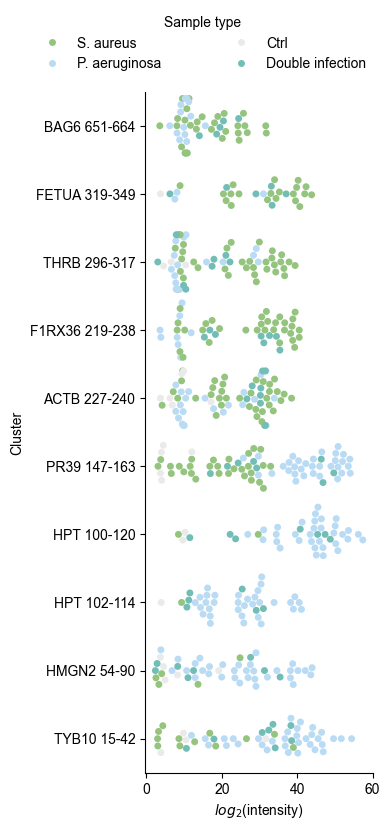

In [10]:
de_sa = de[de["S. aureus_P. aeruginosa_fold"] > 0]
de_sa.sort_values(["DE_score"], ascending=False, inplace=True)
de_sa = de_sa[0:5]["cluster"].values.tolist()

de_pa = de[de["S. aureus_P. aeruginosa_fold"] < 0]
de_pa.sort_values(["DE_score"], ascending=False, inplace=True)
de_pa = de_pa[0:5]["cluster"].values.tolist()

all_clusters = clusters_df
design = pd.read_csv("../data/design.csv")

top_clusters = de_pa + de_sa


top_clusters = topn[topn["Cluster"].isin(top_clusters)].set_index("Cluster").copy().T

design = design[
    design["group"].isin(["S. aureus", "Ctrl", "P. aeruginosa", "Double infection"])
]
top_clusters = top_clusters.merge(design, left_index=True, right_on="sample")


top_clusters.set_index(["group", "day"], inplace=True)
top_clusters.drop(columns=["Unnamed: 0", "sample", "id"], inplace=True)

plot_df = top_clusters.stack().reset_index()
plot_df.rename(columns={"level_2": "Cluster"}, inplace=True)
plot_df = plot_df.merge(all_clusters, left_on="Cluster", right_on="ID")
plot_df["Cluster"] = (
    plot_df["Protein"]
    + " "
    + plot_df["Start"].astype(str)
    + "-"
    + plot_df["End"].astype(str)
)
plot_df.rename(columns={0: r"$log_2$(intensity)"}, inplace=True)
plot_df.replace(0, np.nan, inplace=True)


fig, ax = plt.subplots(1, 1, figsize=(4, 8))

# dummy plots, just to get the Path objects
a = ax.scatter([1, 2], [3, 4], marker="s")
b = ax.scatter([1, 2], [3, 4], marker="^")
(square_mk,) = a.get_paths()
(triangle_up_mk,) = b.get_paths()
a.remove()
b.remove()


sns.swarmplot(
    data=plot_df,
    y="Cluster",
    x="$log_2$(intensity)",
    hue="group",
    palette=group_palette,
)


plt.legend(
    bbox_to_anchor=(-0.5, 1.02, 1.5, 0.05),
    ncols=2,
    mode="expand",
    borderaxespad=0.1,
    title="Sample type",
    frameon=False,
)
sns.despine()
plt.tight_layout()

/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Day 1' 'Day 2']


/Users/erikhartman/dev/pepnets/.venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


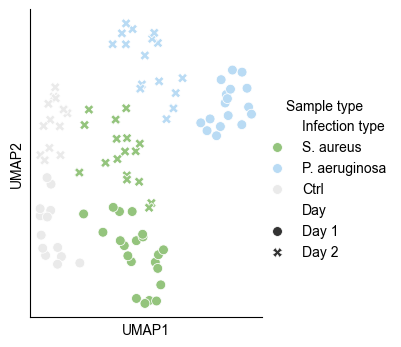

In [11]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from palette import group_palette, day_palette

topn = pd.read_csv("../data/topn.csv")
design = pd.read_csv("../data/design.csv")


groups = ["Ctrl", "S. aureus", "P. aeruginosa"]

design = design[design["group"].isin(groups)].reset_index()

samples = design["sample"]
feature_matrix = topn.set_index("Cluster").T.loc[samples]

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from palette import group_palette, day_palette

X = feature_matrix.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
days = design["day"]
print(days.unique())

y = np.array(design["group"])

le = LabelEncoder()
y_int = le.fit_transform(y)

reducer = UMAP(random_state=42)
X_r = reducer.fit_transform(X)

df = pd.DataFrame(X_r)
df["Day"] = days
df["Infection type"] = y


lw = 2

fig = plt.figure(figsize=(3, 4))

sns.scatterplot(
    df, x=0, y=1, hue="Infection type", palette=group_palette, style="Day", s=50
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.xticks([])
plt.yticks([])
sns.despine()


plt.legend(
    loc="upper left", frameon=False, bbox_to_anchor=(0.95, 0.75), title="Sample type"
)

0.94 accuracy with a standard deviation of 0.06


Text(8.222222222222218, 0.5, 'Prediction')

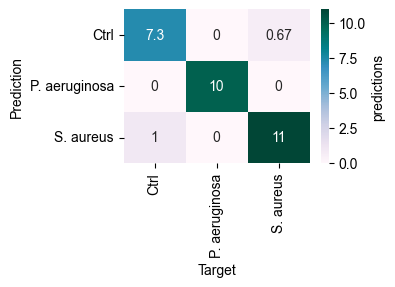

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

clf_xgb = xgboost.XGBClassifier(max_depth=30)
def cross_val(clf, X, y):

    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3)
    scores= []
    cf = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_int[train_index], y_int[test_index]
        clf_xgb.fit(X_train, y_train)
        
        pred = clf_xgb.predict(X_test)
        cf.append(confusion_matrix(y_test, pred))
        scores.append(accuracy_score(y_test, pred))
    scores = np.array(scores)
    return scores, cf
    # get accuracy of each prediction
scores, cf = cross_val(clf_xgb, X, y)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
cf = np.array(cf)
plt.figure(figsize=(3,2))
sns.heatmap(cf.mean(axis=0), annot=True, cmap='PuBuGn', cbar_kws={'label':'predictions'}, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Target')
plt.ylabel('Prediction')


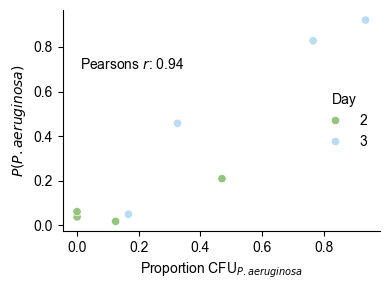

In [13]:

design = pd.read_csv('../data/design.csv')
topn = pd.read_csv('../data/topn.csv')
topn.set_index("Cluster", inplace=True)

training_groups =  ["S. aureus", "P. aeruginosa"]
testing_groups = ["Double infection"]


training_samples = design[design["group"].isin(training_groups)]["sample"]
testing_samples = design[design["group"].isin(testing_groups)]["sample"]

X = topn.T.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

topn = pd.DataFrame(X, columns=topn.index, index = topn.columns)

X_train = topn.loc[training_samples]
X_test = topn.loc[testing_samples]

y_train = np.array(design[design["group"].isin(training_groups)]["group"])
le = LabelEncoder()
y_int = le.fit_transform(y_train)
days = design[design["group"].isin(testing_groups)]["day"]

from sklearn.svm import SVC

ones = np.count_nonzero(y_int)
zeros = len(y_int) - ones

clf_svm = SVC(probability=True, class_weight={0:zeros, 1:ones}, kernel="linear")


clf_svm.fit(X_train, y_int)
probs = clf_svm.predict_proba(X_test)
pa = probs[:,0]
sa = probs[:, 1]

cfu = pd.read_excel("../data/cfu.xlsx")
di = cfu[cfu["group"] == "Double infection"].copy()

di["sa"] = di["swab av sa"] * di["dilution sa"]
di["pa"] = di["swab av pa"] * di["dilution pa"]

di = di[di["day"].isin([2, 3])]
di = di[["sample", "day", "sa", "pa"]]
di["pa/sa"] = di["pa"] / (di["pa"] +  di["sa"])
di["prob_pa"] = pa
plt.figure(figsize=(4,3))
sns.scatterplot(di, x = "pa/sa", y="prob_pa", hue="day", palette=[group_palette["S. aureus"], group_palette["P. aeruginosa"]])

r = np.corrcoef(di["pa/sa"], di["prob_pa"])[0,1]
sns.despine()
plt.xlabel(r"Proportion CFU$_{P. aeruginosa} $")
plt.ylabel(r"$P(P. aeruginosa)$")
plt.text(0.01, 0.7, rf"Pearsons $r$: {r:.2f}")
plt.legend(title="Day", frameon=False, loc="center right")
plt.tight_layout()



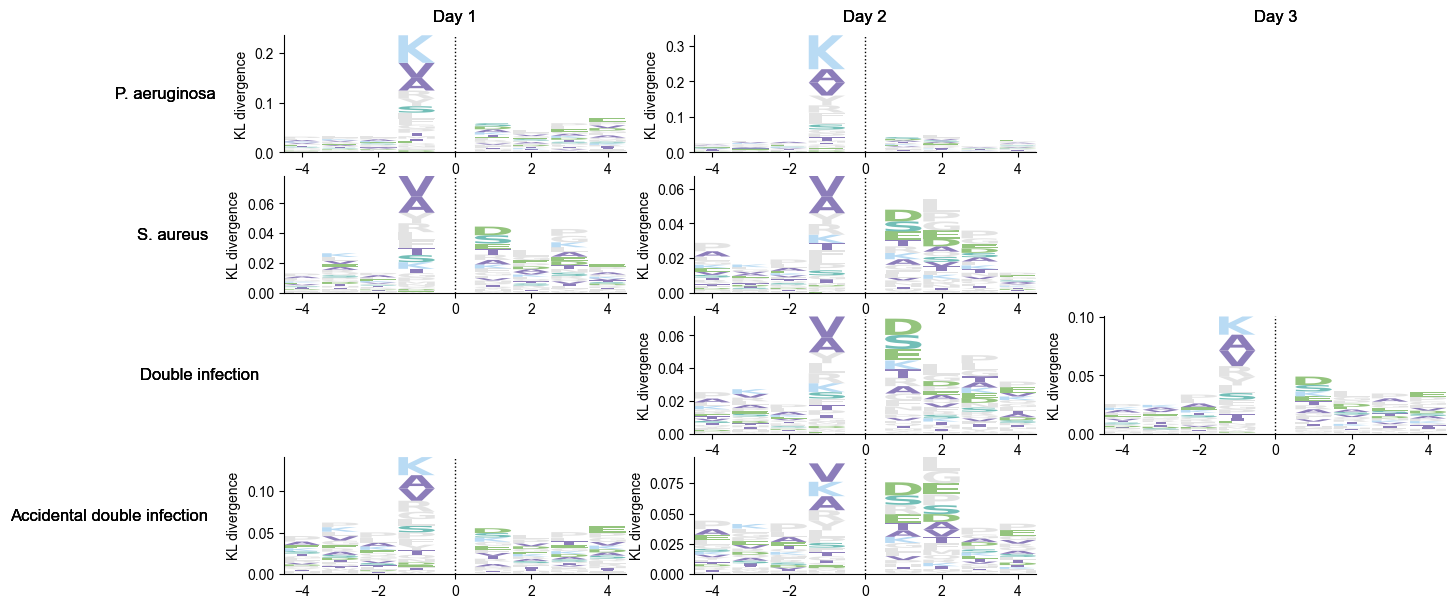

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from pepnets.LogoPlot import LogoPlot
datamatrix = pd.read_csv("../data/processed_datamatrix.csv").dropna(subset=["Start", "End"])

proteins = [p + "_PIG" for p in datamatrix["Protein"].unique()]
database = pd.read_csv("../data/sus_scrofa.gz", sep="\t")
database = database[database["Entry Name"].isin(proteins)]
lp = LogoPlot(datamatrix, design, database, topn)
groups = [
    "P. aeruginosa",
    "S. aureus",
    "Double infection",
]
max_y = 0
background_samples = design[design["group"] == "Ctrl"]["sample"].tolist()
days = ["Day 1", "Day 2", "Day 3"]

fig, axs = plt.subplots(len(groups), len(days), figsize=(15, 7))
for d, day in enumerate(days):
    design_day = design[design["day"] == day]

    for i, test_group in enumerate(groups):
        test_samples = design_day[design_day["group"] == test_group]["sample"].tolist()
        if len(test_samples) == 0:
            axs[i, d].set_xticks([])
            axs[i, d].set_yticks([])
            sns.despine(ax=axs[i, d], left=True, right=True, top=True, bottom=True)
            continue
        height = lp.get_letter_heights(test_samples, background_samples)

        xticks = height.index
        lp.plot(height, ax=axs[i, d])
        sns.despine(ax=axs[i, d])
        axs[i, d].axvline(0, color="k", linewidth=1, linestyle=":")
        axs[i, d].set_ylabel("KL divergence")

        max_y = max(max_y, max(height.sum(axis=1).max(), height.sum(axis=1).max()))

    for ax in axs.ravel():
        # ax.set_ylim(0, max_y)
        continue

    for ax, col in zip(axs[0], days):
        ax.annotate(
            col,
            xy=(0.5, 1),
            xytext=(0, 10),
            xycoords="axes fraction",
            textcoords="offset points",
            size="large",
            ha="center",
            va="baseline",
        )

    for ax, row in zip(axs[:, 0], groups):
        ax.annotate(
            row,
            xy=(0, 0.5),
            xytext=(-ax.yaxis.labelpad - 10, 0),
            xycoords=ax.yaxis.label,
            textcoords="offset points",
            size="large",
            ha="right",
            va="center",
        )

In [15]:
import numpy as np

X = {}
test_samples = [str(x) for x in design[design["group"].isin(["S. aureus", "P. aeruginosa", "Double infection"])]["sample"]]
for i, sample in enumerate(test_samples):
    sample = [str(sample)]
    height = lp.get_letter_heights(sample, background_samples)
    X[sample[0]] = np.reshape(height.values, (height.shape[0]*height.shape[1],))
    

([], [])

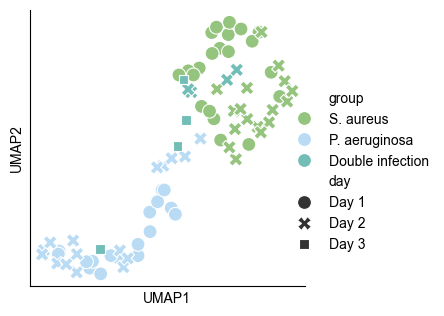

In [16]:
from sklearn.decomposition import PCA
from umap import UMAP
from pepnets.palette import group_palette

p = pd.DataFrame(X)
X_reduced = UMAP().fit_transform(p.T)
plot_df = pd.DataFrame(X_reduced, columns=["UMAP1", "UMAP2"])
design_loc = design.set_index("sample").loc[p.columns]

plot_df = pd.DataFrame(X_reduced, columns=["UMAP1", "UMAP2"])
plot_df["group"] = design_loc.reset_index()["group"]
plot_df["day"] = design_loc.reset_index()["day"]
plot_df["sample"] = design_loc.reset_index(names="sample")["sample"].apply(lambda x: x.split(" ")[-1])


fig = plt.figure(figsize=(3.5, 3.5))
sns.scatterplot(
    plot_df, x="UMAP1", y="UMAP2", hue="group", s=100, style="day", palette=group_palette)
plt.tight_layout()
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(0.9, 0.75))
sns.despine()
plt.xticks([])
plt.yticks([])

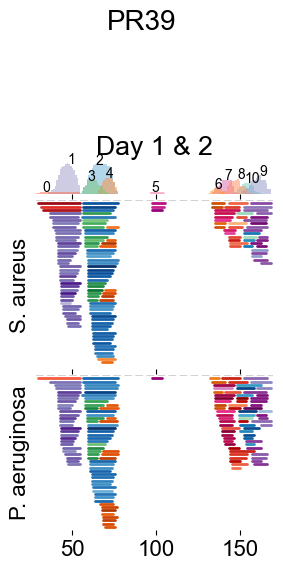

In [17]:
from pepnets.PeptiGrams import PeptiGram

design = pd.read_csv("../data/design.csv")
design["day"] = ["Day 1 & 2" if d in ["Day 1", "Day 2"] else "_" for d in design["day"]]
peptigram = PeptiGram(datamatrix, design)
peptigram.plot_peptigram(
    "PR39", groups=["S. aureus", "P. aeruginosa"], days=["Day 1 & 2"],
    save_str=None
)
